# Agent Chat with Multimodal Models: DALLE  and GPT-4V

Requires: OpenAI V1. 

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [1]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI, AzureOpenAI
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview", "gpt4-vision"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt4-turbo", "gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dalle"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

The `config_list_dalle` should be something like:

```python
[
    {
        'model': 'dalle',
        'api_key': 'Your API Key here',
        'api_version': '2023-06-01-preview'
    }
]
 ```

## Helper Functions

We first create a warpper for DALLE call, make the 

In [3]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.

    This function takes a prompt and other parameters to generate an image using OpenAI's DALL-E model.
    It checks if the result is already cached; if so, it returns the cached image data. Otherwise,
    it calls the DALL-E API to generate the image, stores the result in the cache, and then returns it.

    Args:
        client (OpenAI): The OpenAI client instance for making API calls.
        model (str): The specific DALL-E model to use for image generation.
        prompt (str): The text prompt based on which the image is generated.
        size (str): The size specification of the image. TODO: This should allow specifying landscape, square, or portrait modes.
        quality (str): The quality setting for the image generation.
        n (int): The number of images to generate.

    Returns:
    str: The image data as a string, either retrieved from the cache or newly generated.

    Note:
    - The cache is stored in a directory named '.cache/'.
    - The function uses a tuple of (model, prompt, size, quality, n) as the key for caching.
    - The image data is obtained by making a secondary request to the URL provided by the DALL-E API response.
    """
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

Here is a helper function to extract image from a DALLE agent. We will show the DALLE agent later.

In [4]:
def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    # Function implementation...
    img_data = re.findall("<img (.*)>", agent.last_message()["content"])[0]
    pil_img = _to_pil(img_data)
    return pil_img

## The DALLE Agent

In [5]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
            self.model = config_list[0]["model"]
            azure_endpoint = config_list[0]["base_url"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
            self.model = "dall-e-3"
            azure_endpoint = None
        self.client = (
            OpenAI(api_key=api_key)
            if azure_endpoint is None
            else AzureOpenAI(api_version="2023-12-01-preview", azure_endpoint=azure_endpoint, api_key=api_key)
        )
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self.client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        # TODO: integrate with autogen.oai. For instance, with caching for the API call
        img_data = dalle_call(
            client=self.client,
            model=self.model,
            prompt=prompt,
            size="1024x1024",  # TODO: the size should be flexible, deciding landscape, square, or portrait mode.
            quality="standard",
            n=1,
        )
        out_message = f"<img {img_data}>"
        return True, out_message

## Simple Example: Call directly from User

In [6]:
dalle = DALLEAgent(name="Dalle", llm_config={"config_list": config_list_dalle})

user_proxy = UserProxyAgent(
    name="User_proxy", system_message="A human admin.", human_input_mode="NEVER", max_consecutive_auto_reply=0
)

# Ask the question with an image
user_proxy.initiate_chat(
    dalle,
    message="""Central Icon: Create a simple, stylized icon that represents AI, such as a digital brain or a circuit pattern that subtly forms an "AI" monogram. This icon should be versatile enough to stand alone or work with the text. Typography: Choose a modern, sans-serif font for "AI STUdy Hall" to ensure readability and a contemporary look. This should be the most prominent part of the logo. Color Scheme: Use a base of cool grey or navy blue for the primary elements of the logo to ensure it looks good on a variety of hoodie colors, especially if the hoodies are in darker shades. Accents can be in Microsoft's brand colors but used sparingly, such as for the dot of an 'i' or subtle highlights within the icon. Layout: The layout should be compact to ensure visibility and impact when printed on a hoodie. Consider a stacked design with the icon above and text below, or the icon to the left of the text for a horizontal layout. This makes it adaptable for different hoodie designs and sizes. Simplicity and Versatility: Keep the design simple to ensure it translates well into both print and embroidery. Avoid gradients and fine details that might not render well on fabric.""",
)

User_proxy (to Dalle):

Central Icon: Create a simple, stylized icon that represents AI, such as a digital brain or a circuit pattern that subtly forms an "AI" monogram. This icon should be versatile enough to stand alone or work with the text. Typography: Choose a modern, sans-serif font for "AI STUdy Hall" to ensure readability and a contemporary look. This should be the most prominent part of the logo. Color Scheme: Use a base of cool grey or navy blue for the primary elements of the logo to ensure it looks good on a variety of hoodie colors, especially if the hoodies are in darker shades. Accents can be in Microsoft's brand colors but used sparingly, such as for the dot of an 'i' or subtle highlights within the icon. Layout: The layout should be compact to ensure visibility and impact when printed on a hoodie. Consider a stacked design with the icon above and text below, or the icon to the left of the text for a horizontal layout. This makes it adaptable for different hoodie design

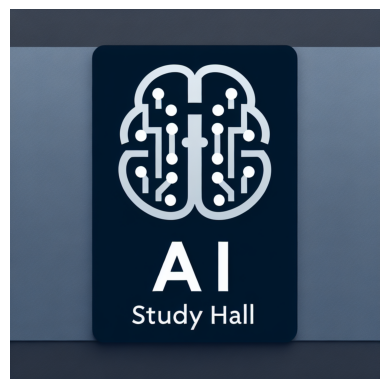

In [7]:
img = extract_img(dalle)

plt.imshow(img)
plt.axis("off")  # Turn off axis numbers
plt.show()

## Example With Critics: Iterate several times to improve

In [6]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=7, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        ## Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=12,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)
        plt.imshow(img)
        plt.axis("off")  # Turn off axis numbers
        plt.show()
        print("Image PLOTTED")

        for i in range(self._n_iters):
            # Downsample the image s.t. GPT-4V can take
            img = extract_img(self.dalle)
            # smaller_image = img.resize((128, 128), Image.Resampling.LANCZOS)
            img.save("result" + str(i) + ".png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            img_prompt = re.findall("PROMPT: (.*)", feedback)[0]

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            plt.imshow(img)
            plt.axis("off")  # Turn off axis numbers
            plt.show()
            print(f"Image {i} PLOTTED")
            img.save("result" + str(i + 1) + ".png")

        return True, "result.jpg"

User (to DALLE Creator!):

A logo for the Developer Community of Microsoft Belux with a white background and the color of Microsoft logo: blue, red, green and yellow.

--------------------------------------------------------------------------------


DALLE Creator! (to Dalle):

A logo for the Developer Community of Microsoft Belux with a white background and the color of Microsoft logo: blue, red, green and yellow.

--------------------------------------------------------------------------------


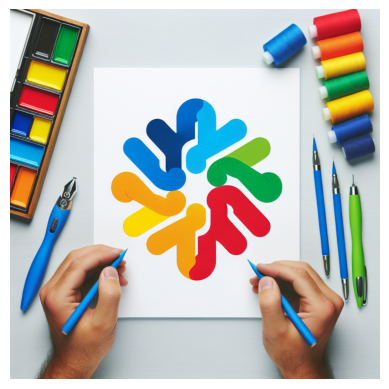

Image PLOTTED
Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
DALLE Creator! (to Critics):

Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
Here is the prompt: A logo for the Developer Community of Microsoft Belux with a white background and the color of Microsoft logo: blue, red, green and yellow..
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE Creator!):

CRITICS: The image needs to improve in terms of incorporating a more distinct and recognizable reference to the Developer Community aspect, perhaps by adding elements that signify development, like code brackets or a stylized 'D'. The Microsoft colors could be more vivid to c

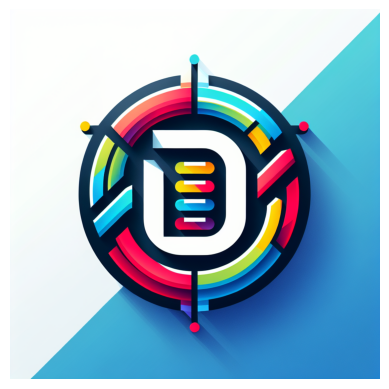

Image 0 PLOTTED
Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
DALLE Creator! (to Critics):

Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
Here is the prompt: Create an updated logo for the Developer Community of Microsoft Belux. The background should be white, featuring a central design that creatively blends a stylized 'D' or code brackets to symbolize development, with the Microsoft logo colors: blue, red, green, and yellow, used in a vibrant and eye-catching way. If text is included, ensure it's clear, legible, and possibly incorporates a modern, tech-inspired font. The overall design should be clean, professional, and reflective of Microsoft's branding, while also being unique to the Developer Community..
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CR

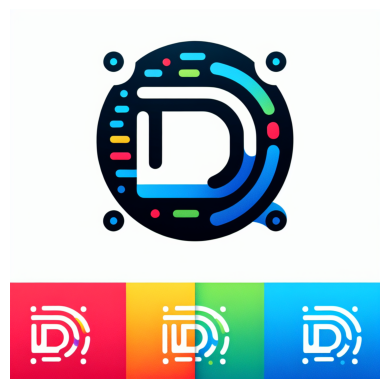

Image 1 PLOTTED
Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
DALLE Creator! (to Critics):

Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
Here is the prompt: Generate a logo for the Microsoft Belux Developer Community with a crisp white backdrop. The logo should prominently feature a bold, stylized 'D' or code brackets (< >) to symbolize development at its core. Apply the signature Microsoft colors - a striking blue, vivid red, lively green, and bright yellow - with increased contrast and saturation for a pop of vibrancy. Any text included should be in a bold, modern, tech-inspired font that is easily readable, and the design should find a balance between professionalism and creativity, making it memorable and distinct while still fitting within the Microsoft brand family..
            Here is the figure <img result.png>.
            Now, critic and create a prompt so t

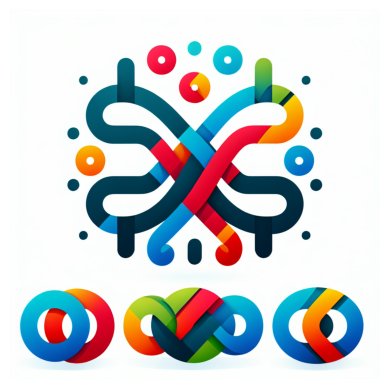

Image 2 PLOTTED
Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
DALLE Creator! (to Critics):

Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
Here is the prompt: Craft a logo for the Developer Community of Microsoft Belux, set against a sharp white background to enhance visibility. The logo must centralize around a dynamic, interconnected stylized 'D' or code brackets (< >), which embodies the essence of development. Infuse the logo with the classic Microsoft colors - a deep, radiant blue, a rich, bold red, a fresh, energetic green, and a warm, luminous yellow - ensuring they are seamlessly integrated into the design for a cohesive look. Text, if present, should utilize a sleek, avant-garde, tech-inspired font that asserts readability. Aim for a balanced, memorable, and scalable design that encapsulates both the spirit of the Microsoft brand and the innovation of the Develo

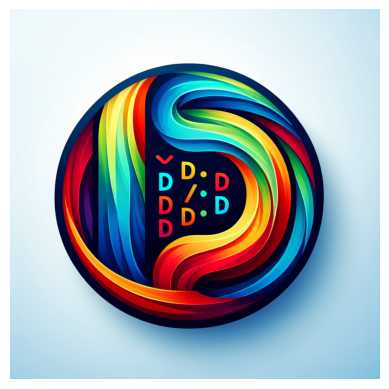

Image 3 PLOTTED
Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
DALLE Creator! (to Critics):

Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
Here is the prompt: Design a cohesive and striking logo for the Microsoft Belux Developer Community, which should be set on a pure white background to make the colors pop. The logo must feature an innovative and fluid stylized 'D' or code brackets (< >), signifying the core of development. The design should fluidly incorporate the iconic Microsoft colors - blending a deep blue, bold red, vibrant green, and bright yellow - in a gradient or layered manner that speaks to unity and innovation. If text is included, it should be intricately integrated within the logo using a futuristic, tech-inspired font, ensuring it is part of the overall design and enhances the logo's symmetry. Focus on creating a logo that is not only balanced and memor

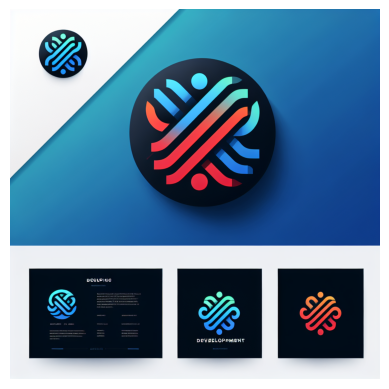

Image 4 PLOTTED
Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
DALLE Creator! (to Critics):

Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
Here is the prompt: Forge a sleek and modern logo for the Microsoft Belux Developer Community, ensuring it stands out against a stark white background. The logo should elegantly showcase a stylized 'D' or code brackets (< >), artistically reimagined to represent development. Integrate the Microsoft color scheme in an understated gradient or layered style that subtly transitions from a deep blue to bold red to vibrant green to bright yellow. Include text in a futuristic, tech-inspired font that merges harmoniously with the rest of the design, enhancing the logo's symmetry and reinforcing the overall concept. Aim for a design that maintains visual balance and brand integrity, ensuring it is memorable and versatile for scaling across dif

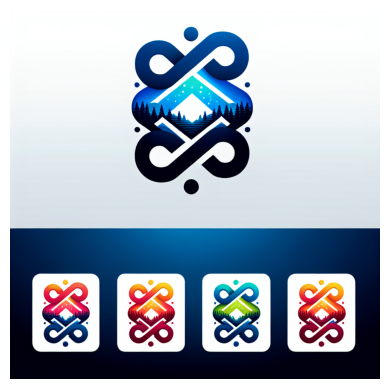

Image 5 PLOTTED
Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
DALLE Creator! (to Critics):

Warning! Unable to load image from result.png, because [Errno 2] No such file or directory: 'result.png'
Here is the prompt: Construct a refined and sophisticated logo for the Microsoft Belux Developer Community on a stark white background for pronounced contrast. The insignia must centrally feature a distinct, elegantly crafted stylized 'D' or code brackets (< >) that epitomizes the foundation of development. The integration of Microsoft's colors should be done with a delicate gradient that gently shifts from a deep blue, through a bold red, into a vibrant green, and finally eases into a bright yellow, ensuring each hue complements the others without overwhelming. Text must be incorporated using a clean, avant-garde, tech-inspired font that aligns perfectly with the design's symmetry and doesn't compete with the central motif. The logo 

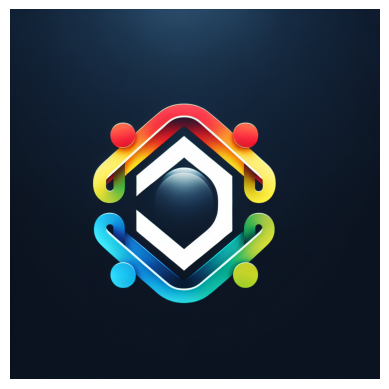

Image 6 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


In [7]:
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator,
    message="""A logo for the Developer Community of Microsoft Belux with a white background and the color of Microsoft logo: blue, red, green and yellow.""",
)